## Importing Required Libraries

## Extracting Files

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [ ]:
c = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
n = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
p = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [ ]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n),2500) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,/kaggle/input/covid19-radiography-database/COV...,2
1,/kaggle/input/covid19-radiography-database/COV...,2
2,/kaggle/input/covid19-radiography-database/COV...,2
3,/kaggle/input/covid19-radiography-database/COV...,2
4,/kaggle/input/covid19-radiography-database/COV...,2


In [ ]:
df.shape

(7461, 2)

## Exploratory Data Analysis

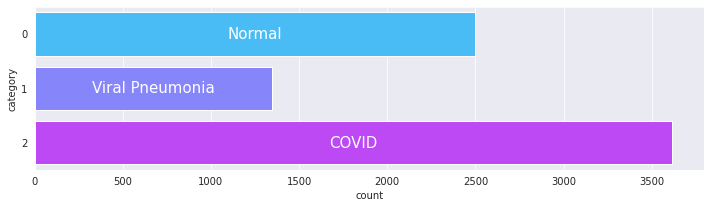

In [ ]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

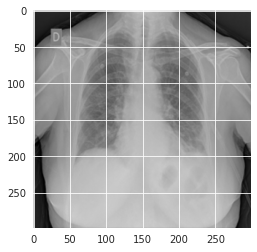

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


In [ ]:
engine = tf.keras.applications.DenseNet121(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),

    )
    
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

2023-02-19 08:41:48.240109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 08:41:48.342979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 08:41:48.343890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 08:41:48.345021: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
 history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=30,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

2023-02-19 08:42:11.001145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-19 08:42:22.059412: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


187/187 [==============================] - 134s 625ms/step - loss: 0.4129 - accuracy: 0.8401 - val_loss: 1.5984 - val_accuracy: 0.5341
Epoch 2/30
187/187 [==============================] - 88s 468ms/step - loss: 0.2212 - accuracy: 0.9199 - val_loss: 1.1442 - val_accuracy: 0.6908
Epoch 3/30
187/187 [==============================] - 89s 473ms/step - loss: 0.1886 - accuracy: 0.9326 - val_loss: 0.8687 - val_accuracy: 0.7122
Epoch 4/30
187/187 [==============================] - 87s 466ms/step - loss: 0.1455 - accuracy: 0.9434 - val_loss: 0.2179 - val_accuracy: 0.9170
Epoch 5/30
187/187 [==============================] - 87s 467ms/step - loss: 0.1389 - accuracy: 0.9507 - val_loss: 0.3721 - val_accuracy: 0.8795
Epoch 6/30
187/187 [==============================] - 92s 493ms/step - loss: 0.1109 - accuracy: 0.9608 - val_loss: 0.1883 - val_accuracy: 0.9357
Epoch 7/30
187/187 [==============================] - 88s 470ms/step - loss: 0.1133 - accuracy: 0.9571 - val_loss: 0.1640 - val_accuracy: 0.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

#### Model Architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# Final Test

In [ ]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [ ]:
 model.evaluate(test_set)

24/24 [==============================] - 6s 268ms/step - loss: 0.0450 - accuracy: 0.9853


[0.04504004865884781, 0.98525470495224]

In [ ]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=2))



                 precision    recall  f1-score   support

         Normal       0.98      0.98      0.98       250
Viral Pneumonia       0.99      0.96      0.97       134
          COVID       0.99      1.00      0.99       362

       accuracy                           0.99       746
      macro avg       0.99      0.98      0.98       746
   weighted avg       0.99      0.99      0.99       746



## Saving Model

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_set.labels,predIdxs )

array([[246,   1,   3],
       [  5, 128,   1],
       [  1,   0, 361]])

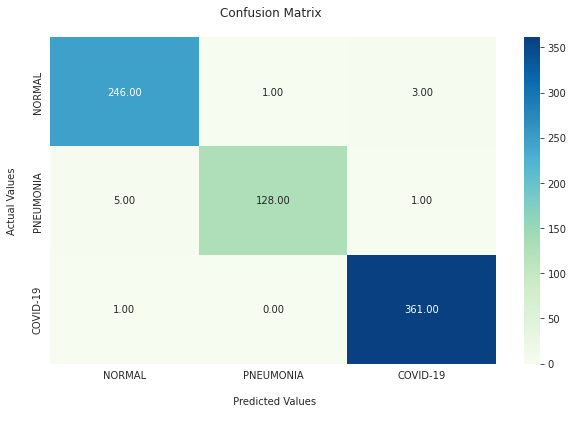

In [ ]:
plt.figure(figsize=(10,6))
import seaborn as sns
fx= sns.heatmap(confusion_matrix(test_set.labels,predIdxs), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['NORMAL','PNEUMONIA','COVID-19'])
fx.yaxis.set_ticklabels(['NORMAL','PNEUMONIA','COVID-19'])
plt.show()

In [ ]:
model.save('Covid.h5')

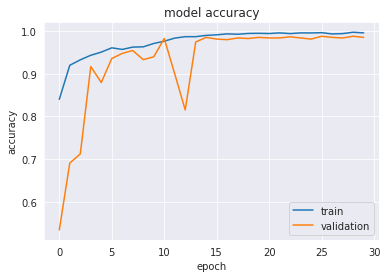

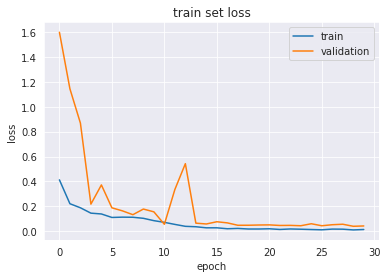

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Model Testing

In [ ]:
loss, accuracy = model.evaluate(valid_generator)

24/24 [==============================] - 3s 112ms/step - loss: 0.0427 - accuracy: 0.9853
